In [8]:
from autodistill_grounding_dino import GroundingDINO
from autodistill.detection import CaptionOntology
import cv2
import supervision as sv
import duckdb
from core_pro.ultilities import make_sync_folder

In [9]:
path = make_sync_folder('Item_Matching_Test')
file = path / 'result_match_image/Fashion Accessories__Additional Accessories__Charms, Pendants & Ornaments.parquet'

query = f"""
select * 
from read_parquet('{file}')
where q_item_id = 24282169285
"""
df = duckdb.sql(query).pl()
df.head()

shape: (1, 25)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ q_item_id ┆ q_item_na ┆ q_shop_id ┆ q_shop_na ┆ … ┆ db_item_n ┆ db_file_p ┆ db_exists ┆ score_im │
│ ---       ┆ me        ┆ ---       ┆ me        ┆   ┆ ame_clean ┆ ath       ┆ ---       ┆ age_embe │
│ i64       ┆ ---       ┆ i64       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ list[bool ┆ d        │
│           ┆ str       ┆           ┆ str       ┆   ┆ list[str] ┆ list[str] ┆ ]         ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ list[f32 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ ]        │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 242821692 ┆ St.       ┆ 284378953 ┆ St.Kunkka ┆ … ┆ ["st.     ┆ ["/home/k ┆ [true,    ┆ [1.0,    │
│ 85        ┆ kunkka 10 ┆           ┆ Boutique  ┆   ┆ kunkka 10 ┆ evin/Down ┆ true, …   ┆ 0.820331 │
│           ┆ Chiếc     ┆           ┆ Beads     ┆   ┆ chiếc     ┆ loads/Dat ┆ true]     ┆ , … 0.77 │
│           ┆ Acrylic   ┆           ┆           ┆   ┆ acrylic … ┆ a/I…      ┆           ┆ 5301]    │
│           ┆ Hạ…       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [10]:
run_q = df[['q_item_name', 'q_category', 'q_file_path']].to_dicts()
run_q[0]

{'q_item_name': 'St. kunkka 10 Chiếc Acrylic Hạt Hoa Thời Trang Quyến Rũ Mặt Dây Chuyền Có Thể Được Sử Dụng Cho DIY Trang Sức Làm Vòng Cổ Vòng Tay',
 'q_category': 'Fashion Accessories__Additional Accessories__Charms, Pendants & Ornaments',
 'q_file_path': '/home/kevin/Downloads/Data/Item_Matching_Test/download_img_Fashion/img_/00001/0000118859.jpg'}

In [11]:
run_db = df[['db_item_name', 'db_category', 'db_file_path', 'score_image_embed']].to_dicts()[:2]
run_db[0]

{'db_item_name': ['St. kunkka 10 Chiếc Acrylic Hạt Hoa Thời Trang Quyến Rũ Mặt Dây Chuyền Có Thể Được Sử Dụng Cho DIY Trang Sức Làm Vòng Cổ Vòng Tay',
  'St. kunkka Bộ 4 Hạt Nhựa acrylic Hình Hoa Rỗng Dùng Làm Vòng Tay / Dây Chuyền diy',
  'St.kunkka Set 10 Hạt Xâu Chuỗi Hình Ngôi Sao Năm Cánh Bằng acrylic Trong Suốt 30mm Làm Trang Sức diy',
  'St. kunkka 5-10 Chiếc Hạt Hoa Gốm Nhiều Màu Cho Vòng Cổ Vòng Tay Hoa DIY',
  'St.kunkka Set 50 Hạt Xỏ Lỗ Hình Hoa 14mm Nhiều Màu Sắc Làm Trang Sức Thủ Công',
  'St. kunkka 2-10 Chiếc Hoa Nhiều Màu Sắc Gốm Rời Miếng Đệm Hạt 12 Mm Năm Cánh Hạt Hoa Cho DIY Phụ Kiện Trang Sức',
  'St. kunkka 2-10 Chiếc Hoa Nhiều Màu Sắc Gốm Rời Miếng Đệm Hạt 12 Mm Năm Cánh Hạt Hoa Cho DIY Phụ Kiện Trang Sức',
  'St.kunkka 10-30 Chiếc hạt hoa 10.5*11.5mm hạt hoa thủy tinh cho đồ trang sức DIY',
  'St. kunkka 5-10 Chiếc Hợp Kim Hạt Khung Retro Hình Hoa Cho DIY Phụ Kiện Trang Sức',
  'St. kunkka 5-10 Chiếc Hợp Kim Hạt Khung Retro Hình Hoa Cho DIY Phụ Kiện Trang Sức'],


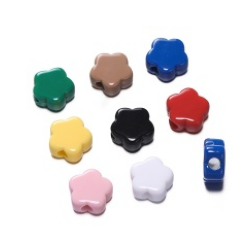

In [12]:
sv.plot_image(cv2.imread(run_q[0]['q_file_path']), size=(3, 3))

In [17]:
from collections import defaultdict


box_lst, crop_lst = [], defaultdict(list)
for lst_match in run_db[:]:
    for c, p in zip(lst_match['db_category'], lst_match['db_file_path']):
        item_ = c.split('__')[-1]
        # item = 'Charms'
        img_path = p
        base_model = GroundingDINO(ontology=CaptionOntology({f"{item_}": f"{item_}"}))
        result = base_model.predict(img_path)

        # plot
        box_annot = sv.BoxAnnotator()
        image = cv2.imread(img_path)
        img_annot = box_annot.annotate(scene=image.copy(), detections=result)
        box_lst.append(img_annot)

        # crop
        for i in result.xyxy:
            crop_img = sv.crop_image(image=image.copy(), xyxy=i)
            # crop_lst.append(crop_img)
        # break
    break

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


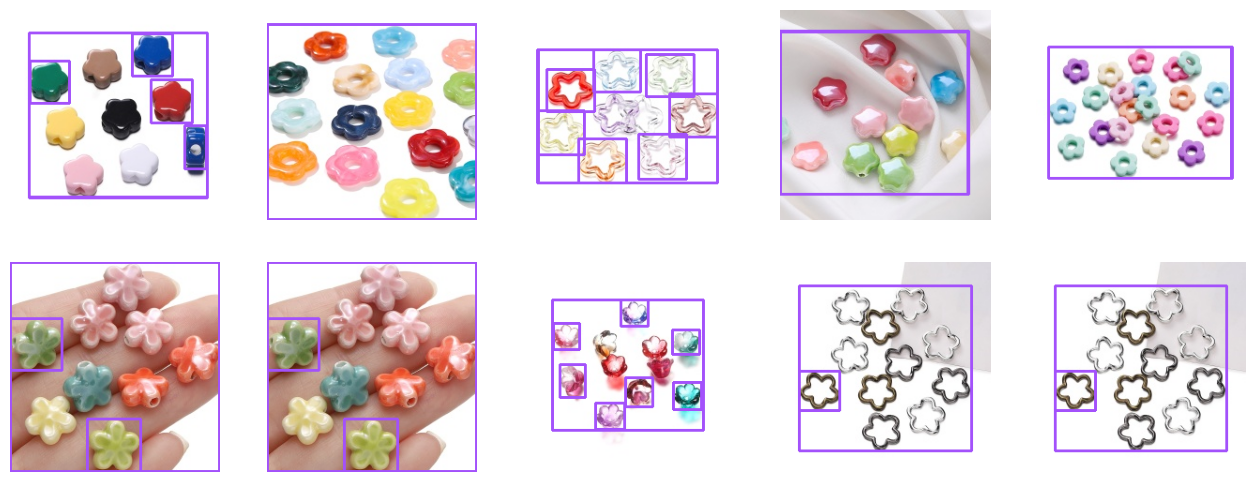

In [18]:
sv.plot_images_grid(box_lst, grid_size=(2, 5), size=(16, 6))

In [15]:
box_lst

[]